In [1]:
##Comment out this cell if you want to see warnings about depreciations, upgrades, etc, involving Cuda/Cudnn/Tensorflow
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'


# Additional lines to suppress TensorFlow warnings
#import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import sys
import os
import tensorflow as tf

# Print Python, Driver, and TensorFlow versions
print("Python and Driver Version:", sys.version)
print("TensorFlow Version:", tf.__version__)

# Set GPU as the Default Device
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU(s),", len(logical_gpus), "Logical GPU(s)")
        print("GPU set as the default device.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

# Check GPU Availability
GPU_LIST = tf.config.list_physical_devices('GPU')
print("GPU found?:", len(GPU_LIST) > 0)
print("Num GPUs Available:", len(GPU_LIST))

# Display Local Devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Python and Driver Version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
TensorFlow Version: 2.13.0
1 Physical GPU(s), 1 Logical GPU(s)
GPU set as the default device.
GPU found?: True
Num GPUs Available: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11087282862648905092
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7917797376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13853296519165163734
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
### Calculates/prints the average execution time for each iteration
### for TensorFlow GPU, TensorFlow CPU, Torch GPU, and Torch CPU. 
### By iterating multiple times, the performance comparison becomes more reliable.

import tensorflow as tf
import torch

num_iterations = 200

# TensorFlow GPU
tf_gpu_total_time = 0
for _ in range(num_iterations):
    with tf.device('/GPU:0'):
        tf_gpu_start = tf.timestamp()
        # Your TensorFlow GPU computations here
        a = tf.random.normal((1000, 1000))
        b = tf.random.normal((1000, 1000))
        tf_gpu_result = tf.matmul(a, b)
        tf_gpu_end = tf.timestamp()
    tf_gpu_total_time += (tf_gpu_end - tf_gpu_start)

# TensorFlow CPU
tf_cpu_total_time = 0
for _ in range(num_iterations):
    with tf.device('/CPU:0'):
        tf_cpu_start = tf.timestamp()
        # Your TensorFlow CPU computations here
        a = tf.random.normal((1000, 1000))
        b = tf.random.normal((1000, 1000))
        tf_cpu_result = tf.matmul(a, b)
        tf_cpu_end = tf.timestamp()
    tf_cpu_total_time += (tf_cpu_end - tf_cpu_start)

# Torch GPU
torch.cuda.init()
torch_gpu_total_time = 0
for _ in range(num_iterations):
    torch_gpu_start = torch.cuda.Event(enable_timing=True)
    torch_gpu_end = torch.cuda.Event(enable_timing=True)
    torch_gpu_start.record()
    # Your Torch GPU computations here
    a = torch.randn(1000, 1000).cuda()
    b = torch.randn(1000, 1000).cuda()
    torch_gpu_result = torch.matmul(a, b)
    torch_gpu_end.record()
    torch.cuda.synchronize()
    torch_gpu_total_time += torch_gpu_start.elapsed_time(torch_gpu_end) / 1000.0

# Torch CPU
torch_cpu_total_time = 0
for _ in range(num_iterations):
    torch_cpu_start = torch.cuda.Event(enable_timing=True)
    torch_cpu_end = torch.cuda.Event(enable_timing=True)
    torch_cpu_start.record()
    # Your Torch CPU computations here
    a = torch.randn(1000, 1000)
    b = torch.randn(1000, 1000)
    torch_cpu_result = torch.matmul(a, b)
    torch_cpu_end.record()
    torch.cuda.synchronize()
    torch_cpu_total_time += torch_cpu_start.elapsed_time(torch_cpu_end) / 1000.0

# Calculate average execution time
tf_gpu_avg_execution_time = tf_gpu_total_time / num_iterations
tf_cpu_avg_execution_time = tf_cpu_total_time / num_iterations
torch_gpu_avg_execution_time = torch_gpu_total_time / num_iterations
torch_cpu_avg_execution_time = torch_cpu_total_time / num_iterations

# Compare performance
print(f"TensorFlow GPU average execution time: {tf_gpu_avg_execution_time} seconds")
print(f"TensorFlow CPU average execution time: {tf_cpu_avg_execution_time} seconds")
print(f"Torch GPU average execution time: {torch_gpu_avg_execution_time} seconds")
print(f"Torch CPU average execution time: {torch_cpu_avg_execution_time} seconds")


TensorFlow GPU average execution time: 0.0016772317886352538 seconds
TensorFlow CPU average execution time: 0.007544354200363159 seconds
Torch GPU average execution time: 0.008020776309967033 seconds
Torch CPU average execution time: 0.012086472654342652 seconds


In [49]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to load CIFAR-10 dataset and get class names
def load_cifar10():
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return x_train, y_train, x_test, y_test, class_names  # Return class names

# Function to create a CNN model
def create_cnn_model():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Function to train the model
def train_model(model, x_train, y_train, x_test, y_test, batch_size, epochs, device_name):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start_time = time.time()
    
    with tqdm(total=epochs * (len(x_train) // batch_size), desc=f"Batch Size: {batch_size}, Device: {device_name}", unit="batch") as pbar:
        for epoch in range(epochs):
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                model.train_on_batch(x_batch, y_batch)
                pbar.update(1)
    
    end_time = time.time()
    training_time = end_time - start_time
    return training_time

# Function to evaluate the model and get accuracy and confusion matrix
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_classes)
    confusion_mat = confusion_matrix(y_test, y_pred_classes)
    return accuracy, confusion_mat

# Calculate specificity from the confusion matrix
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix.sum(axis=0) - confusion_matrix.diagonal()
    false_positives = confusion_matrix.sum(axis=1) - confusion_matrix.diagonal()
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

# Calculate AUC-ROC score
def calculate_auc_roc(model, x_test, y_test):
    y_pred = model.predict(x_test)
    auc_roc = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")
    return auc_roc

# Load CIFAR-10 dataset and get class names
x_train, y_train, x_test, y_test, class_names = load_cifar10()

# Set batch sizes to test
batch_sizes = [512, 2048, 4096]
epochs = 10  # Number of training epochs

# Initialize results dictionary with "Device" column
results = {
    "Device": [],
    "Batch Size": [],
    "Training Time (s)": [],
    "Accuracy": [],
    "Recall": [],
    "Precision": [],
    "Specificity": [],
    "AUC-ROC": [],
    "Confusion Matrix": [],
}

# Train and evaluate the model with different batch sizes for both CPU and GPU
for batch_size in batch_sizes:
    print(f"Training with Batch Size: {batch_size}")
    
    # Train on CPU
    print("Training on CPU...")
    results["Device"].append("CPU")
    with tf.device('/CPU:0'):
        cpu_model = create_cnn_model()
        cpu_training_time = train_model(cpu_model, x_train, y_train, x_test, y_test, batch_size, epochs, "CPU")
    
    cpu_accuracy, cpu_confusion = evaluate_model(cpu_model, x_test, y_test)
    cpu_recall = recall_score(y_test, np.argmax(cpu_model.predict(x_test), axis=1), average="macro")
    cpu_precision = precision_score(y_test, np.argmax(cpu_model.predict(x_test), axis=1), average="macro")
    cpu_specificity = calculate_specificity(cpu_confusion)
    cpu_auc_roc = calculate_auc_roc(cpu_model, x_test, y_test)

    results["Batch Size"].append(batch_size)
    results["Training Time (s)"].append(cpu_training_time)
    results["Accuracy"].append(cpu_accuracy)
    results["Recall"].append(cpu_recall)
    results["Precision"].append(cpu_precision)
    results["Specificity"].append(cpu_specificity.mean())
    results["AUC-ROC"].append(cpu_auc_roc)
    results["Confusion Matrix"].append(cpu_confusion)

    # Train on GPU
    print("Training on GPU...")
    results["Device"].append("GPU")
    with tf.device('/GPU:0'):
        gpu_model = create_cnn_model()
        gpu_training_time = train_model(gpu_model, x_train, y_train, x_test, y_test, batch_size, epochs, "GPU")
    
    gpu_accuracy, gpu_confusion = evaluate_model(gpu_model, x_test, y_test)
    gpu_recall = recall_score(y_test, np.argmax(gpu_model.predict(x_test), axis=1), average="macro")
    gpu_precision = precision_score(y_test, np.argmax(gpu_model.predict(x_test), axis=1), average="macro")
    gpu_specificity = calculate_specificity(gpu_confusion)
    gpu_auc_roc = calculate_auc_roc(gpu_model, x_test, y_test)

    results["Batch Size"].append(batch_size)
    results["Training Time (s)"].append(gpu_training_time)
    results["Accuracy"].append(gpu_accuracy)  # Corrected this line
    results["Recall"].append(gpu_recall)
    results["Precision"].append(gpu_precision)
    results["Specificity"].append(gpu_specificity.mean())
    results["AUC-ROC"].append(gpu_auc_roc)
    results["Confusion Matrix"].append(gpu_confusion)

# Create a DataFrame from the results dictionary
df = pd.DataFrame(results)


Training with Batch Size: 512
Training on CPU...


Batch Size: 512, Device: CPU: 980batch [01:46,  9.18batch/s]                      


313/313 [==============================] - 1s 3ms/step
Training on GPU...


Batch Size: 512, Device: GPU: 980batch [00:18, 52.45batch/s]                      


313/313 [==============================] - 0s 1ms/step
Training with Batch Size: 2048
Training on CPU...


Batch Size: 2048, Device: CPU: 250batch [01:41,  2.47batch/s]                      


313/313 [==============================] - 1s 3ms/step
Training on GPU...


Batch Size: 2048, Device: GPU: 250batch [00:12, 19.47batch/s]                      


313/313 [==============================] - 0s 1ms/step
Training with Batch Size: 4096
Training on CPU...


Batch Size: 4096, Device: CPU: 130batch [01:40,  1.30batch/s]                      


313/313 [==============================] - 1s 3ms/step
Training on GPU...


Batch Size: 4096, Device: GPU: 130batch [00:11, 11.60batch/s]                      


313/313 [==============================] - 0s 1ms/step


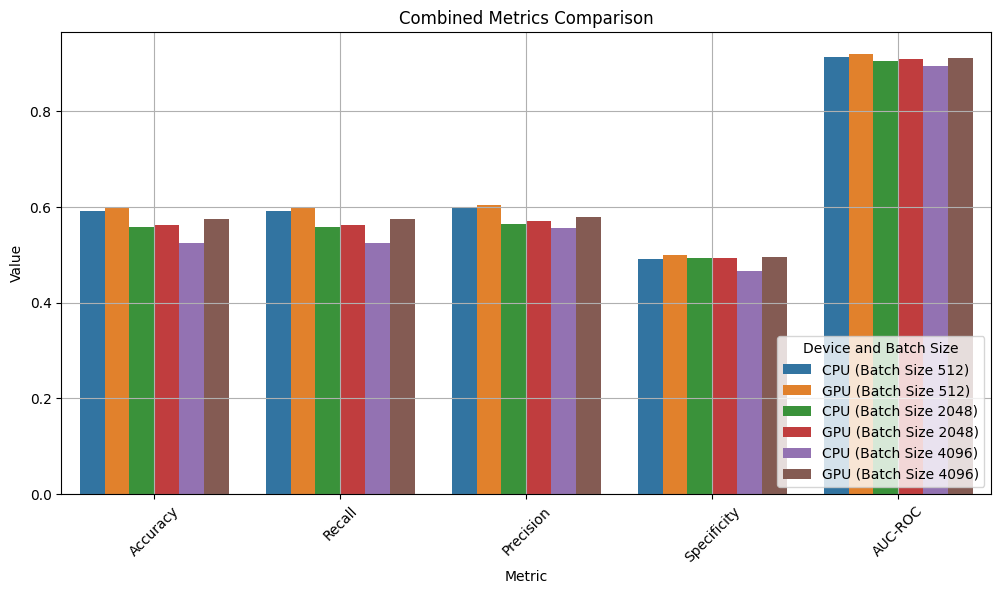

In [50]:
# Add a new column combining "Device" and "Batch Size"
df['Device_Batch'] = df['Device'] + " (Batch Size " + df['Batch Size'].astype(str) + ")"

# Plotting (Combined Metrics: Accuracy, Recall, Precision, Specificity, AUC-ROC)
metrics = ["Accuracy", "Recall", "Precision", "Specificity", "AUC-ROC"]

combined_metrics_data = []
for metric in metrics:
    for device_batch in df['Device_Batch'].unique():
        metric_value = df[df['Device_Batch'] == device_batch][metric].values[0]
        combined_metrics_data.append((metric, device_batch, metric_value))

combined_metrics_df = pd.DataFrame(combined_metrics_data, columns=["Metric", "Device_Batch", "Value"])

plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Value", hue="Device_Batch", errorbar=None, data=combined_metrics_df)
plt.title("Combined Metrics Comparison")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(True)
plt.legend(title="Device and Batch Size", loc='lower right')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()




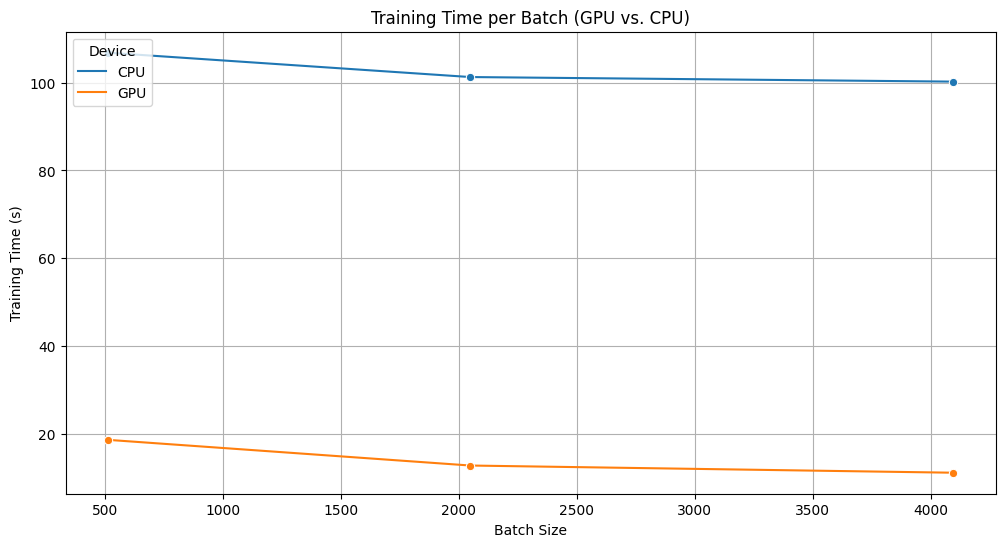

In [51]:

# Training Time per Batch (Line Graph for GPU/CPU)
training_time_data = df[df["Device"].isin(["CPU", "GPU"])]

plt.figure(figsize=(12, 6))
sns.lineplot(x="Batch Size", y="Training Time (s)", hue="Device", data=training_time_data, marker="o")
plt.title("Training Time per Batch (GPU vs. CPU)")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.legend(title="Device", loc="upper left")
plt.show()


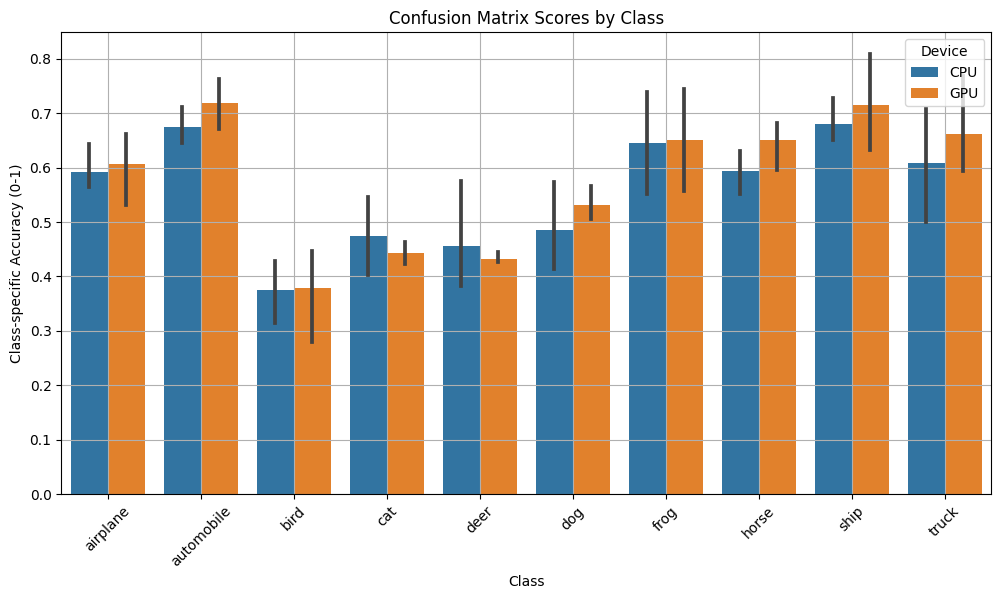

In [52]:
# Initialize an empty dictionary to store confusion matrix scores
confusion_data = {
    "Device": [],
    "Batch Size": [],
    "Class": [],
    "Class-specific Accuracy": [],
}

# Iterate through devices and batch sizes to calculate scores by class
for device in ["CPU", "GPU"]:
    for batch_size in batch_sizes:
        df_batch = df[(df["Device"] == device) & (df["Batch Size"] == batch_size)]
        confusion_matrices = df_batch["Confusion Matrix"].values

        # Average the confusion matrices if there are multiple entries
        avg_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

        # Calculate scores (0-1) for each class based on the confusion matrix
        total_per_class = avg_confusion_matrix.sum(axis=1)
        correct_per_class = np.diag(avg_confusion_matrix)
        scores_per_class = correct_per_class / total_per_class

        # Add the data to the dictionary
        for class_index, class_name in enumerate(class_names):
            confusion_data["Device"].append(device)
            confusion_data["Batch Size"].append(batch_size)
            confusion_data["Class"].append(class_name)
            confusion_data["Class-specific Accuracy"].append(scores_per_class[class_index])

# Create a DataFrame from the confusion data
confusion_df = pd.DataFrame(confusion_data)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Class-specific Accuracy", hue="Device", data=confusion_df)
plt.title("Confusion Matrix Scores by Class")
plt.xlabel("Class")
plt.ylabel("Class-specific Accuracy (0-1)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Device", loc="upper right")
plt.show()


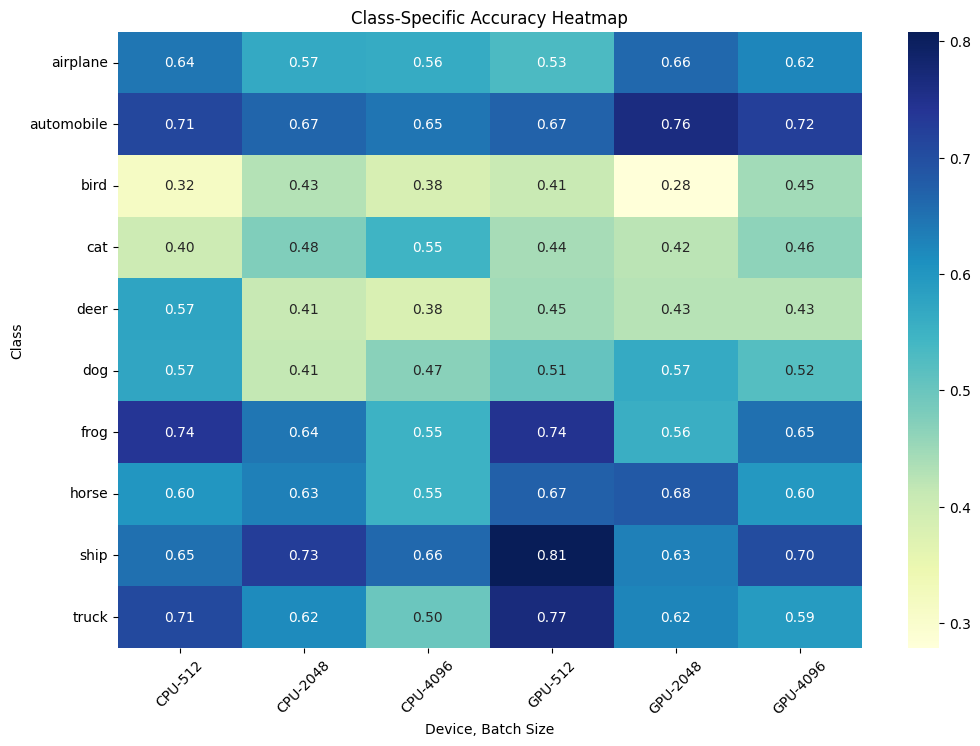

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'confusion_df' containing class-specific accuracy data
# 'confusion_df' should have columns: 'Device', 'Batch Size', 'Class', and 'Class-specific Accuracy'

# Pivot the data to create a heatmap grid
heatmap_data = confusion_df.pivot(index='Class', columns=['Device', 'Batch Size'], values='Class-specific Accuracy')

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Class-Specific Accuracy Heatmap')
plt.xlabel('Device, Batch Size')
plt.ylabel('Class')
plt.xticks(rotation=45)
plt.show()


In [54]:
# Calculate mean and standard deviation for each class, GPU/CPU, and batch size combination
summary_data = confusion_df.groupby(['Class', 'Device', 'Batch Size'])['Class-specific Accuracy'].agg(['mean', 'median']).reset_index()

# Calculate the class-specific rank based on the 'mean' score for each combination
summary_data['Class Specific Rank'] = summary_data.groupby(['Class'])['mean'].rank(ascending=False).astype(int)

# Display the statistical summary
print(summary_data)


         Class Device  Batch Size   mean  median  Class Specific Rank
0     airplane    CPU         512  0.644   0.644                    2
1     airplane    CPU        2048  0.567   0.567                    4
2     airplane    CPU        4096  0.564   0.564                    5
3     airplane    GPU         512  0.532   0.532                    6
4     airplane    GPU        2048  0.662   0.662                    1
5     airplane    GPU        4096  0.623   0.623                    3
6   automobile    CPU         512  0.711   0.711                    3
7   automobile    CPU        2048  0.667   0.667                    5
8   automobile    CPU        4096  0.645   0.645                    6
9   automobile    GPU         512  0.671   0.671                    4
10  automobile    GPU        2048  0.763   0.763                    1
11  automobile    GPU        4096  0.724   0.724                    2
12        bird    CPU         512  0.315   0.315                    5
13        bird    CP

In [55]:
df= summary_data

# Create a pivot table to count the occurrences of each rank for each combination
pivot_table = pd.pivot_table(df, index=["Device", "Batch Size"], columns="Class Specific Rank", aggfunc='size', fill_value=0)

# Calculate the weighted average for each combination
weights = np.arange(1, len(pivot_table.columns) + 1)  # Weights for all ranks
pivot_table["Weighted Average"] = (pivot_table * weights).sum(axis=1) / pivot_table.sum(axis=1)

# Reset the index to make "Device" and "Batch Size" columns
pivot_table.reset_index(inplace=True)

# Rename the columns for better clarity
pivot_table.columns.name = None

# Add an "Overall Rank" column based on "Weighted Average" and sort by it in ascending order
pivot_table["Overall Rank"] = pivot_table["Weighted Average"].rank()

# Sort the DataFrame by "Weighted Average" in ascending order
pivot_table.sort_values(by="Weighted Average", ascending=True, inplace=True)

print(pivot_table)


  Device  Batch Size  1  2  3  4  5  6  Weighted Average  Overall Rank
3    GPU         512  3  2  1  3  0  1               2.8           1.0
0    CPU         512  2  3  1  1  2  1               3.1           2.5
5    GPU        4096  1  1  6  0  2  0               3.1           2.5
4    GPU        2048  3  1  1  1  2  2               3.4           4.0
1    CPU        2048  0  3  1  3  2  1               3.7           5.0
2    CPU        4096  1  0  0  2  2  5               4.9           6.0
